In [91]:
def readtextfile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [92]:
captions = readtextfile('text/Flickr8k.token.txt')

In [93]:
captions

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [5]:
len(captions.split('\n'))

40460

In [94]:
captions = captions.split('\n')
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

### creating a dictionary with image name mapping to captions
- dictionary with key as image name and values as captions

In [95]:
descriptions = {}

for x in captions:
    l= x.split('\t')
    first = l[0]
    second = l[1]
    img_name = first.split('.')[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(second)

In [96]:
descriptions['1002674143_1b742ab4b8']

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

# Data Cleaning

In [97]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Dropout , Embedding, LSTM
from keras.layers.merge import add


- dont remove stop words
- dont do stemming as model needs to learn stemming and stop words for being gramatically correct
- remove numbers
- remove puntuations
- reduce vocab size

- why making vocab size low
- vocabulary size is low means less no of dense layers(neurons) 
- means less parameters
- no overfitting

In [98]:
def cleantext(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    # replace all the letters which are not in range of a to z to blamk spaces
    sentence = sentence.split()
    
    # sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [99]:
cleantext("A Cat is sitting 67 over house no.1024")

'a cat is sitting over house no'

In [100]:
# clean each caption in the descriptions dictionary

for key,captionlist in descriptions.items():
    for i in range(len(captionlist)):
        captionlist[i]=cleantext(captionlist[i])

In [101]:
f = open("descriptions.txt","w")
f.write(str(descriptions))
f.close()

### vocabulary creation
- vocab is set of all possible words that model can use to generate captions
- from descriptions clean then then find all the unique words in that
- that forms a vocabulary
- while predictions the model sees probability of which word is high
- that word is taken for captioning
- so index of word is given with probablity , that index we have to search in vocab and print it

In [102]:
# to open the file saved go through these steps
# the file read is in form of string so convrt it in dictionary 
# we do json conversion
'''
descriptions = None
with open (descriptions.txt,'r') as f:
    descriptions = f.read()
    
json_acceptable_file = descriptions.replace("'","\")  # json accepts this way only
descriptions = json.loads(json_acceptable_file)
'''

'\ndescriptions = None\nwith open (descriptions.txt,\'r\') as f:\n    descriptions = f.read()\n    \njson_acceptable_file = descriptions.replace("\'","")  # json accepts this way only\ndescriptions = json.loads(json_acceptable_file)\n'

In [103]:
# to create vocab of unique words we use set
vocab = set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    # for all sentence split them to list of words 
    # iterate through words and all unique words are inserted in set
    
len(vocab)

8441

In [104]:
# see how many total words are present

totalwords = []
for key in descriptions.keys():
    [totalwords.append(i) for des in descriptions[key] for i in des.split()]
    
print(len(totalwords))

437466


In [105]:
import collections
counter = collections.Counter(totalwords)
freq_cnt=dict(counter)
# counter has words and their corresponding frequencies
# convert it into dictionary and print
print(freq_cnt)

{'a': 62995, 'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14

- now we are finding frequency of occurance of each word
- to further decrease the vocab size we can remove the words whose freq is less than 10

In [106]:
sort_freq = sorted(freq_cnt.items(),reverse = True,key = lambda x:x[1])
# this line sorts the items in dictionary according to values( frequency)
sort_freq

[('a', 62995),
 ('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her',

In [107]:
# filter words less than frequency 5
sort_freq = [x for x in sort_freq if x[1] > 5]
# if frequency is greater than 5 keep otherwise remove
filtered_totalwords = [x[0] for x in sort_freq]

print (len(filtered_totalwords))

2644


- previously total words were 437466 now after filtering its 2644
- now updating these words as our new vocab
- thus further reduced vocab size

### loading training image set
- prepare train and test data

In [108]:
traindata = readtextfile('text/Flickr_8k.trainImages.txt')
testdata = readtextfile('text/Flickr_8k.testImages.txt')

In [109]:
traindata  # need to split with respect to \n as it appers in paragraph form

'2513260012_03d33305cf.jpg\n2903617548_d3e38d7f88.jpg\n3338291921_fe7ae0c8f8.jpg\n488416045_1c6d903fe0.jpg\n2644326817_8f45080b87.jpg\n218342358_1755a9cce1.jpg\n2501968935_02f2cd8079.jpg\n2699342860_5288e203ea.jpg\n2638369467_8fc251595b.jpg\n2926786902_815a99a154.jpg\n2851304910_b5721199bc.jpg\n3423802527_94bd2b23b0.jpg\n3356369156_074750c6cc.jpg\n2294598473_40637b5c04.jpg\n1191338263_a4fa073154.jpg\n2380765956_6313d8cae3.jpg\n3197891333_b1b0fd1702.jpg\n3119887967_271a097464.jpg\n2276499757_b44dc6f8ce.jpg\n2506892928_7e79bec613.jpg\n2187222896_c206d63396.jpg\n2826769554_85c90864c9.jpg\n3097196395_ec06075389.jpg\n3603116579_4a28a932e2.jpg\n3339263085_6db9fd0981.jpg\n2532262109_87429a2cae.jpg\n2076906555_c20dc082db.jpg\n2502007071_82a8c639cf.jpg\n3113769557_9edbb8275c.jpg\n3325974730_3ee192e4ff.jpg\n1655781989_b15ab4cbff.jpg\n1662261486_db967930de.jpg\n2410562803_56ec09f41c.jpg\n2469498117_b4543e1460.jpg\n69710415_5c2bfb1058.jpg\n3414734842_beb543f400.jpg\n3006217970_90b42e6b27.jpg\n2192

In [110]:
train = [row.split(".")[0] for row in traindata.split('\n')[:-1]]
test = [row.split(".")[0] for row in testdata.split('\n')[:-1]]

# from above para graph split with respect to \n
# then split with respect to . to obtain image id and remove jpg

In [111]:
print(train[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']


In [112]:
# prepare descriptions for training data
# add <s> and <e> tokens to all the captions
# so that our model can identify where sentence starts  and where captions ends

train_descript = {}

for img_id in train:
    train_descript[img_id] = []
    for caption in descriptions[img_id]:
        train_descript[img_id].append("startseq " + caption + " endseq")

In [113]:
train_descript

{'2513260012_03d33305cf': ['startseq a black dog is running after a white dog in the snow endseq',
  'startseq black dog chasing brown dog through snow endseq',
  'startseq two dogs chase each other across the snowy ground endseq',
  'startseq two dogs play together in the snow endseq',
  'startseq two dogs running through a low lying body of water endseq'],
 '2903617548_d3e38d7f88': ['startseq a little baby plays croquet endseq',
  'startseq a little girl plays croquet next to a truck endseq',
  'startseq the child is playing croquette by the truck endseq',
  'startseq the kid is in front of a car with a put and a ball endseq',
  'startseq the little boy is playing with a croquet hammer and ball beside the car endseq'],
 '3338291921_fe7ae0c8f8': ['startseq a brown dog in the snow has something hot pink in its mouth endseq',
  'startseq a brown dog in the snow holding a pink hat endseq',
  'startseq a brown dog is holding a pink shirt in the snow endseq',
  'startseq a dog is carrying 

## Image preprosessing

## Transfer Learning 
- image --> features
- text --> features

- in order to extract features from the images we are using pre-trained model
- we are using resnet50 that is pretrained with Imagenet data
- it is very deep model has 50 layers
- also has skip connections so that backpropagation can happen easily
- so that it does not suffer the problem of vanishing gradient
- this model is pretrained with images of size 224x224x3

In [114]:
model = ResNet50(weights = "imagenet",input_shape = (224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### given an image as input this resnet 50 will convert it into a lsit of 2048 numbers
### that is the features extracted from image

In [115]:
modelnew = Model(model.input,model.layers[-2].output)

In [116]:
from keras.applications.resnet50 import preprocess_input


def imagepreprocess(img):
    img = image.load_img(img,target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis =0)
    
    # we have to mormalize our image
    # resnet50 provides its own normalization bultin function = preprocess_input
    img = preprocess_input(img)
    return img

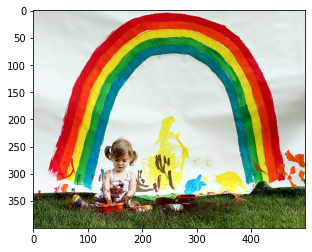

In [117]:
import cv2
i = cv2.imread("Flicker8k_Dataset/1002674143_1b742ab4b8.jpg")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
plt.imshow(i)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


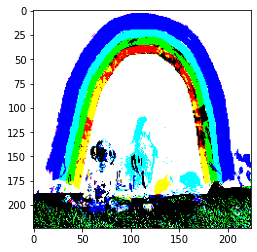

In [118]:
i = imagepreprocess("Flicker8k_Dataset/1002674143_1b742ab4b8.jpg")
plt.imshow(i[0])
plt.show()

In [119]:
def img2fea(img):
    img = imagepreprocess(img)
    featurevector = modelnew.predict(img)
    featurevector = featurevector.reshape((2048,))
    return featurevector

In [120]:
i = img2fea("Flicker8k_Dataset/1002674143_1b742ab4b8.jpg")

In [121]:
print(i.shape)
i

(2048,)


array([0.08419637, 0.61375225, 0.2070151 , ..., 0.        , 3.0910757 ,
       1.5620651 ], dtype=float32)

### now do the image to vector conversion for all images in training set

In [122]:
featureconverted = {}

for ix,img_id in enumerate(train):
    imgpath = "Flicker8k_Dataset/"+img_id+".jpg"
    featureconverted[img_id]=img2fea(imgpath)

### takes almost half an hour

### store this data to disk in file 
### so use pikle to store and retrive data from database

In [123]:
with open("feature_converted_train.pkl","wb") as f:
    pickle.dump(featureconverted,f)

### do same with test data also

In [124]:
featureconverted_test = {}

for ix,img_id in enumerate(test):
    imgpath = "Flicker8k_Dataset/"+img_id+".jpg"
    featureconverted_test[img_id]=img2fea(imgpath)

In [125]:
with open("feature_converted_test.pkl","wb") as f:
    pickle.dump(featureconverted_test,f)

In [181]:
len(featureconverted)

6000

- we have converted images into numbers(arrays)
- now we have to also convert captions into numbers
- every word is feature and every word is represented by a number
- that is index of the number
- we have to feed this numbersto model

### word to index convert

In [127]:
len(filtered_totalwords)

2644

In [128]:
word2idx = {}
idx2word = {}

for i,word in enumerate(filtered_totalwords):
    word2idx[word] = i+1
    idx2word[i+1] = word

In [129]:
word2idx['girl']

17

In [130]:
# we also have to add 2 more words 'startseq' and 'endseq'

word2idx['startseq'] = 2645
word2idx['endseq'] = 2646

idx2word[2645] = 'startseq'
idx2word[2646] = 'endseq'

In [131]:
len(idx2word)

2646

In [132]:
maxlen = 0

for key in train_descript.keys():
    for cap in train_descript[key]:
        maxlen = max(maxlen,len(cap.split()))
        
print(maxlen)

38


- maximun length of sentence = 38

# Data loader or data generator fn

In [260]:
def data_generator(train_descript,featureconverted,word2idx,maxlen,batch_size):
    x1,x2,y = [],[],[]
    # x1 is image vector
    # x2 is partial caption
    # y is output obtained by giving x1 and x2
    n = 0
    while True:
        for key,desclist in train_descript.items():
            n+=1
            image = featureconverted[key]
            for desc in desclist:
                seq = [word2idx[word] for word in desc.split() if word in word2idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                
                    # to make all x and y of equal size do zero padding

                    xi = pad_sequences([xi],maxlen = maxlen,value =0,padding = 'post')[0]
                    yi = to_categorical([yi],num_classes = vocab_Size[0]
                    
                    x1.append(image)
                    x2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield[[np.array(x1),np.array(x2)],np.array(y)]
                    x1,x2,y = [],[],[]
                    n = 0
                    

SyntaxError: invalid syntax (<ipython-input-260-eba65e6fa07e>, line 23)

In [266]:
def data_generator(train_descriptions,encoding_train,word_to_index,max_len,batch_size):
    #batch_size is how many training examples we should have in 1 batch.
    #Our data has 2 parts-:1)Image 2)Partial Captions.
    #We are going to build partial captions
    X1,X2,y=[],[],[]
    n=0
    while True:
        for key,caption_list in train_descriptions.items():
            n+=1
            photo=encoding_train[key]
            for caption in caption_list:
                sequence=[word_to_index[word] for word in caption.split() if word in word_to_index]
                #for all unknown words(not present in word_to_index) ,we are going to ignore it 
                for i in range(1,len(sequence)):
                    xi=sequence[0:i]
                    yi=sequence[i]
                    #Later ,we will do padding which will ensure every xi is of same length
                    #using pad_sequences function available in keras,It accepts a 2D list and returns a 2D Matrix.
                    #[[xi]]--->Here xi is a 2D matrix.
                    #0 denote padding word
                    #padding='post' means we are adding zeros after Sequence of words.
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]#Since we have only one example,so we are extracting only first one..
                    yi=to_categorical([yi],num_classes=vocab_size)[0]#yi should be one hot vector.
                    #xi and yi --->one training point
                    #In our mini batch,we are going to append these values.
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    if n==batch_size:
                        yield[[np.array(X1),np.array(X2)],np.array(y)]
                        #We are not using return function as it is a Generator 
                        #and Generator remembers the state where the function was in the previous call 
                        #For next batch When control comes back again to this Generator Function:-
                        X1,X2,y=[],[],[]
                        n=0

In [265]:
vocab_size = len(filtered_totalwords)
vocab_size = vocab_size+2
print(vocab_size)

2646


# word embeddings

In [267]:
# to convert each word to 50 dimentional vector
f = open('glove.6B.50d.txt',encoding ='utf8') 

In [268]:
for line in f:
    values = line.split()
    print (values)
    break

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581']


In [269]:
embeddings = {}
for line in f:
    values = line.split()
    
    word = values[0]
    word_embd = np.array(values[1:],dtype ='float')
    
    embeddings[word] = word_embd

In [270]:
embeddings['girl']

array([-0.34471 ,  0.69563 , -0.78086 , -0.58482 ,  1.2263  ,  1.2544  ,
       -0.76466 ,  0.40575 ,  0.18862 ,  0.098834,  0.32557 , -0.31816 ,
        0.23869 ,  0.33554 ,  1.0592  , -0.25266 , -1.0308  ,  0.70027 ,
        0.030457,  0.53866 , -0.30279 ,  1.7515  ,  0.3128  ,  1.2103  ,
        0.41335 , -1.9421  , -0.93756 ,  0.32453 ,  0.52249 , -0.86708 ,
        2.1258  , -0.20377 , -0.19061 ,  0.37736 ,  0.66205 ,  0.50211 ,
       -0.12544 , -0.83069 ,  0.21155 , -1.3091  , -0.44973 , -0.11648 ,
        0.033598, -0.68382 ,  0.99419 , -0.88262 ,  0.56601 , -1.327   ,
        0.37319 ,  0.022389])

In [271]:
f.close()

In [272]:
def embedding_matrix():
    dim = 50
    matrix = np.zeros((2646,dim))  # 2646 is total number of words including startseq and endseq
    for word,idx in word2idx.items():
        embd_vect = embeddings.get(word)
        
        if embd_vect is not None:
            matrix[idx] = embd_vect
            
    return matrix

In [273]:
embd_matrix = embedding_matrix()
embd_matrix.shape

(2646, 50)

## Model Architecture

In [274]:
vocab_size = 2646

In [275]:
input_img_features = Input(shape = (2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [276]:
from keras.layers import Input, Dense, Dropout , Embedding, LSTM

input_captions = Input(shape=(maxlen,))
inp_cap1 = Embedding(input_dim = vocab_size,output_dim = 50,mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [286]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation = 'softmax')(decoder2)

In [287]:
#combining above two models
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

TypeError: call() got an unexpected keyword argument 'outputs'

In [288]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 38, 50)       132300      input_13[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_12[0][0]                   
____________________________________________________________________________________________

In [289]:
Model.layers[2].set_weights([embd_matrix])
Model.layers[2].trainable = False

In [290]:
Model.compile(loss = 'categorical_crossentropy',optimizer = "adam")

## training of model

In [291]:
epochs = 20
batch_size = 3
steps = len(train_descript)//batch_size

In [292]:
def train_model():
    for i in range(epochs):
        generator = data_generator(train_descript,featureconverted,word2idx,maxlen,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save_weights('./model_weights/model_'+str(i)+'.h5')

In [293]:
train_model()

IndexError: index 2646 is out of bounds for axis 1 with size 2646

In [190]:
featureconverted

{'2513260012_03d33305cf': array([0.34707975, 0.51159143, 0.08728843, ..., 1.1897299 , 0.04043845,
        0.15271072], dtype=float32),
 '2903617548_d3e38d7f88': array([0.        , 0.00307797, 0.09360033, ..., 0.43103397, 0.37985346,
        0.9165756 ], dtype=float32),
 '3338291921_fe7ae0c8f8': array([0.7674461 , 0.5342264 , 0.3832519 , ..., 0.02098645, 0.18429351,
        0.0427001 ], dtype=float32),
 '488416045_1c6d903fe0': array([6.2481076e-01, 3.2965484e-01, 1.7821789e-04, ..., 1.2753806e+00,
        4.6392557e-01, 4.9036077e-01], dtype=float32),
 '2644326817_8f45080b87': array([0.11555307, 0.65965426, 0.05323302, ..., 0.14397334, 1.0179373 ,
        0.0055659 ], dtype=float32),
 '218342358_1755a9cce1': array([1.7061832 , 0.4051477 , 0.35206556, ..., 0.29408935, 0.04833034,
        0.04654419], dtype=float32),
 '2501968935_02f2cd8079': array([0.1060828 , 1.4420809 , 0.04447002, ..., 0.2058717 , 0.6978759 ,
        1.590432  ], dtype=float32),
 '2699342860_5288e203ea': array([0.4612

In [2]:
import matplotlib.pyplot as plt


Text(0.5, 0, 'No.of Epochs')

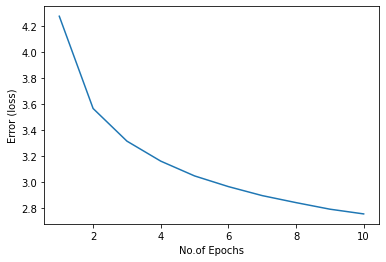

In [7]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [4.2791, 3.5671, 3.3153, 3.1609, 3.0468, 2.9644, 2.8949, 2.8408, 2.7902, 2.7536]
plt.plot(x,y)
plt.ylabel('Error (loss)')
plt.xlabel('No.of Epochs')

Text(0.5, 0, 'No.of Epochs')

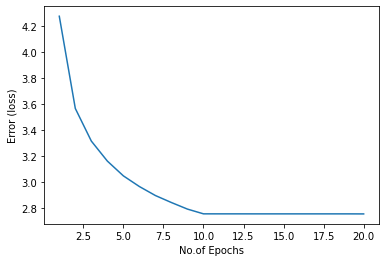

In [8]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
y = [4.2791, 3.5671, 3.3153, 3.1609, 3.0468, 2.9644, 2.8949, 2.8408, 2.7902, 2.7536, 2.7535, 2.7535, 2.7534, 2.7534, 2.7534, 2.7534, 2.7534, 2.7534,2.7534,2.7530 ]
plt.plot(x,y)
plt.ylabel('Error (loss)')
plt.xlabel('No.of Epochs')